KNN
===

In [3]:
%load_ext autoreload
%autoreload 2

import mlflow
import pickle
import pandas as pd 
import numpy as np 

from datetime import datetime
from functions import plt_matrix_confusion

from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configs

In [4]:
EXPERIMENT_TITLE = "Titanic Dataset Analyzes"

run_description = """
### Descrição

Implementação usando [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.htmll)
"""

tags = {
    "date": datetime.now(),
    "author": "Pablo Veinberg",
    "version": 1.0,
    "envoronment": "local",
    "mlflow.note.content": run_description,
    "mlflow.runName": "KNeighborsClassifier",
    "data_source": "./../datasets/silver/train-encoded-not-normalize.parquet",
    "train_test_dataset": "./../datasets/silver/titanic-train-test-data.pkl"
}

params = {
    "token": np.random.randint(10_000,high=20_000),
    "min_n_neighbors": 2,
    "max_n_neighbors": 26,
    "metric": "minkowski", 
    "min_p": 1, "max_p": 3
    }

sns.set_style("darkgrid")


In [5]:
dataset = pd.read_parquet(tags['data_source'])
mlflow_dataset = mlflow.data.from_pandas(dataset, \
                                            source=tags['data_source'], \
                                            name="Titanic Dataset")

/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/data/dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [6]:
with open('./../datasets/silver/titanic-train-test-data.pkl', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

In [7]:
# run all then select best and log

accuracies = []
for k in range(params['min_n_neighbors'], params['max_n_neighbors'], 2):
    for p in (params['min_p'], params['max_p']):
        model = KNeighborsClassifier(
            n_neighbors=k, \
            p=p,
            metric=params['metric']
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracies.append(
            (k, p, accuracy_score(y_test, y_pred)))



In [8]:
sorted_by_accuracy = sorted(accuracies, key=lambda tup: tup[2], reverse=True)

params['n_neighbors'] = sorted_by_accuracy[0][0]
params['p'] = sorted_by_accuracy[0][1]
tags['accuracies'] = accuracies

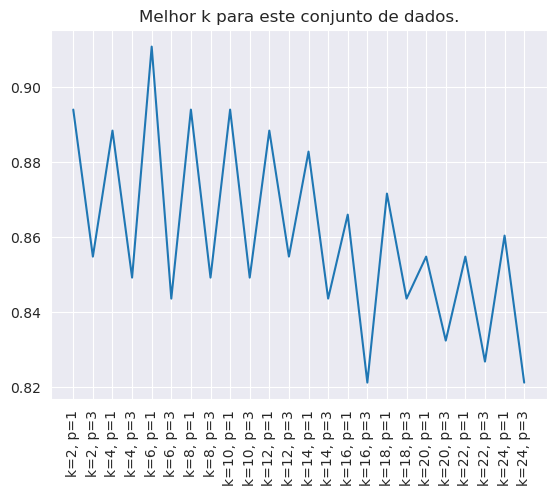

In [9]:
plt_best_k_figpath = f"./../results/knn_best_k_{params['token']}.png"
sns.lineplot(x=[f"k={row[0]}, p={row[1]}" for row in accuracies], y=[row[2] for row in accuracies])
plt.xticks(rotation=90)
plt.title("Melhor k para este conjunto de dados.")
plt.savefig(plt_best_k_figpath);

In [10]:
mlflow.set_experiment(EXPERIMENT_TITLE)

with mlflow.start_run():

    # Settings
    mlflow.log_input(mlflow_dataset)
    mlflow.set_tags(tags)
    mlflow.log_params(params)

    model = KNeighborsClassifier(
                n_neighbors=params['n_neighbors'], \
                p=params['p'],
                metric=params['metric']
        )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mlflow.log_metric("accuracy_score", accuracy_score(y_test, y_pred))    
    mlflow.log_artifact(plt_best_k_figpath)

    plot_confusion_matrix_path = f"./../results/conf_matrix_knn_{params['token']}.png"
    plt_matrix_confusion(y_test, y_pred, plot_confusion_matrix_path, "Matrix Confusion - Titanic Dataset")
    mlflow.log_artifact(plot_confusion_matrix_path)
    
mlflow.end_run()

Traceback (most recent call last):
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 303, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infer_schema(self._df)
